In [1]:
!pip install kaggle
!kaggle datasets download -d guare13/handwritten-letters-recognition
!unzip handwritten-letters-recognition.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid_letters/letter_3363.png  
  inflating: valid_letters/letter_33630.png  
  inflating: valid_letters/letter_33631.png  
  inflating: valid_letters/letter_33632.png  
  inflating: valid_letters/letter_33633.png  
  inflating: valid_letters/letter_33634.png  
  inflating: valid_letters/letter_33635.png  
  inflating: valid_letters/letter_33636.png  
  inflating: valid_letters/letter_33637.png  
  inflating: valid_letters/letter_33638.png  
  inflating: valid_letters/letter_33639.png  
  inflating: valid_letters/letter_3364.png  
  inflating: valid_letters/letter_33640.png  
  inflating: valid_letters/letter_33641.png  
  inflating: valid_letters/letter_33642.png  
  inflating: valid_letters/letter_33643.png  
  inflating: valid_letters/letter_33644.png  
  inflating: valid_letters/letter_33645.png  
  inflating: valid_letters/letter_33646.png  
  inflating: valid_letters/letter_33648.png  
  inflating: valid_letters/lett

In [2]:
import torch
import tensorflow as tf
import os
import cv2
import imghdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from itertools import chain
import random
import shutil
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F

In [3]:
train = pd.read_csv('written_letters_train.csv')
validation = pd.read_csv('written_letters_validation.csv')

In [4]:
characters = sorted(set("".join(train['nombre'].astype(str))))
char_to_label = {char: idx for idx, char in enumerate(characters)}
label_to_char = {idx: char for char, idx in char_to_label.items()}

In [5]:
path_val = "valid_letters"
path_test = "test_letters"
path_train = "train_letters"

In [6]:
class DataGenerator(Dataset):
    def __init__(self, dataframe, path, char_map, img_size=(14, 10), transform=None):
        self.dataframe = dataframe
        self.path = path
        self.char_map = char_map
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe['id'].values[idx]
        img = cv2.imread(os.path.join(self.path, img_path), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.img_size)
        img = img / 255.0
        if self.transform:
            img = self.transform(img)
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)

        text = str(self.dataframe['nombre'].values[idx])
        label = torch.tensor([self.char_map[char] for char in text], dtype=torch.long)
        return img, label

In [7]:
# Transformación para las imágenes
transform = transforms.Compose([
    transforms.ToTensor()
])

In [8]:
train_generator=DataGenerator(train,path_train,char_to_label)
validation_generator=DataGenerator(validation,path_val,char_to_label)

In [14]:
train_loader = DataLoader(train_generator, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_generator, batch_size=128, shuffle=False)

In [15]:
# Defineix el model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        """
        Entren imatges amb 3 canals de color (RGB) i amb aquesta capa convolucional
        s'estreuen característiques loclas de la imatge detectant patrons com bordes,
        textures i altres detalls que poden ser importants.
        """
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        """
        El max pooling redueix la dimensionalitat dels mapas de característiques,
        disminuint la mida de les imatges i retenint les característiques més importants
        Això ajuda a reduir el sobreajustament i millora l'eficàcia computacional.
        """
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.dropout = nn.Dropout(0.5)
        """
        Les següents dues capes s'ecarreguen de la classificació final. Transformen
        les característiques extretes per les capas convolucionals i de pooling a les
        propietats de les diferents classes (lletres).
        """
        self.fc1 = nn.Linear(16 * 7 * 5, 64)
        self.fc2 = nn.Linear(64, 29)  # 29 perquè hi ha 29 caràcters a l'alfabet

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 7 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [33]:
# Instancia el model, defineix la pèrdua i l'optimitzador
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

Epoch 1/20, Train Loss: 2.8384, Train Acc: 0.1825, Test Loss: 2.6479, Test Acc: 0.2798
Epoch 2/20, Train Loss: 2.1366, Train Acc: 0.4697, Test Loss: 1.6375, Test Acc: 0.5753
Epoch 3/20, Train Loss: 1.3628, Train Acc: 0.6397, Test Loss: 1.1949, Test Acc: 0.6735
Epoch 4/20, Train Loss: 1.0655, Train Acc: 0.7176, Test Loss: 0.9920, Test Acc: 0.7306
Epoch 5/20, Train Loss: 0.9161, Train Acc: 0.7550, Test Loss: 0.8786, Test Acc: 0.7632
Epoch 6/20, Train Loss: 0.8294, Train Acc: 0.7798, Test Loss: 0.8122, Test Acc: 0.7845
Epoch 7/20, Train Loss: 0.7719, Train Acc: 0.7969, Test Loss: 0.7655, Test Acc: 0.7970
Epoch 8/20, Train Loss: 0.7298, Train Acc: 0.8103, Test Loss: 0.7274, Test Acc: 0.8109
Epoch 9/20, Train Loss: 0.6985, Train Acc: 0.8194, Test Loss: 0.6992, Test Acc: 0.8205
Epoch 10/20, Train Loss: 0.6718, Train Acc: 0.8280, Test Loss: 0.6751, Test Acc: 0.8269
Epoch 11/20, Train Loss: 0.6495, Train Acc: 0.8352, Test Loss: 0.6671, Test Acc: 0.8304
Epoch 12/20, Train Loss: 0.6308, Train Ac

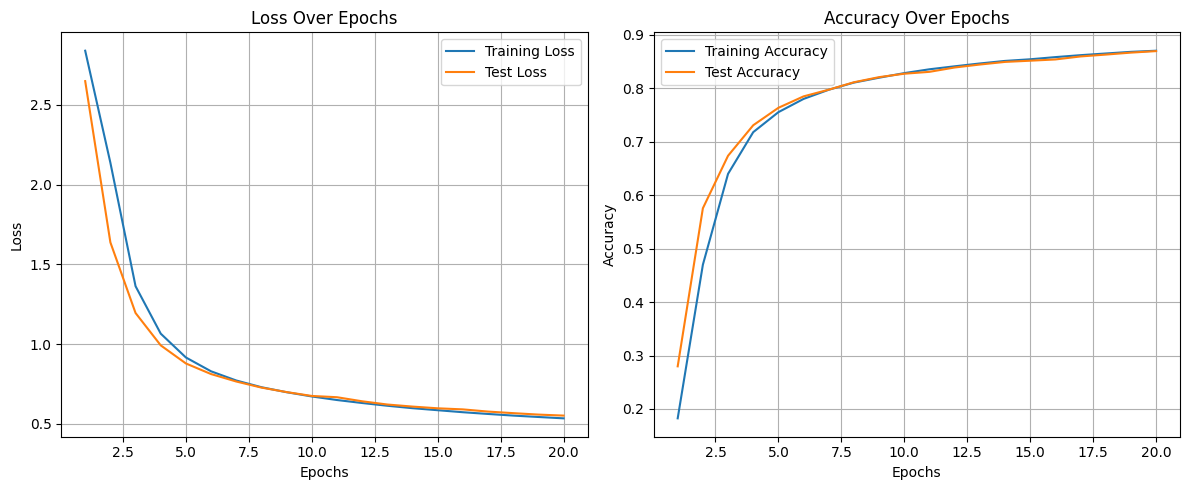

In [34]:
# Entrenar el modelo
num_epochs = 20
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Entrenamiento
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.view(-1)).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Evaluación en el conjunto de validación
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            outputs = model(images)
            loss = criterion(outputs, labels.view(-1))

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.view(-1)).sum().item()

    epoch_loss = running_loss / len(validation_loader)
    epoch_accuracy = correct / total
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")

# Guardar el modelo entrenado
torch.save(model.state_dict(), 'simple_cnn_model.pth')

# Crear la gráfica de pérdida y precisión
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [35]:
def compare_letter_pairs(true_labels, predicted_labels):
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Les llistes han de tenir la mateixa longitud")

    total_pairs = len(true_labels)
    same_letter_count = 0
    total_letters = 0

    for label1, label2 in zip(true_labels, predicted_labels):
        if label1 == label2:
            same_letter_count += 1

        total_letters += 1

    letter_percentage = (same_letter_count / total_letters) * 100

    return same_letter_count, letter_percentage

# Exemple d'ús amb les prediccions del model
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in validation_generator:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

same_letter_count, letter_percentage = compare_letter_pairs(true_labels, predicted_labels)
print(f'Nombre de lletres correctes: {same_letter_count}')
print(f'Percentatge de lletres correctes: {letter_percentage}%')

Nombre de lletres correctes: 17006
Percentatge de lletres correctes: 86.91607891239906%
